# Comparison of latent space models for the study of neural population dynamics

Code by: Pedro Herrero-Vidal
Created: 11/21/2020
Last updated: 12/13/2020

In [1]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from scipy import interpolate
import random

In [2]:
from scipy.linalg import orthogonal_procrustes

def fitting_err(true_seq, estim_seq):
    
    errT = []
    for ii in range(true_seq.shape[2]):
        foo1 = true_seq[:,:,ii]
        foo2 = estim_seq[:,:,ii]

        R, sca = orthogonal_procrustes(foo2, foo1)
        foo3 = np.dot(foo2, R)

        err = 0
        for ii in range(true_seq.shape[0]):
            err += np.corrcoef(foo1[ii, :], foo3[ii, :])[0,1]

        errT.append(err/true_seq.shape[0])
    return errT

In [3]:
# local own implementations
%load_ext autoreload
%autoreload 2
from FRNN_wang_2006 import firing_rate_network, plot_NetworkAct_Input
from Bouroukan2017 import spiking

# Data generation

## Low-diemensional latent: Initiate and simulate dynamics firing-rate model
Simulate firing-rate network with parameters $a=270Hz/nA, b=108Hz, d=.154s, \gamma=.64, \tau_s=.1s, g_E=.28nA, g_I=.047nA, g_{ext}=.00052nA, I_0=.3255nA$, $\tau_0=2ms$, noise amplitude $\sigma=.02$. We set initial conditions of $s_1=s_2=.1$.

In [4]:
network = firing_rate_network()

nTrials = 5
aS1, aS2, aR1, aR2, I1, I2, Td = network.simulation(I_1=10, I_2=0, I_12= 0, 
                                               t= 6, dt = 0.1/100,
                                               t1=.5, t2=1.5, t12=3.5, 
                                               pulse_t1=3,  pulse_t2=.8, pulse_t12=.75, 
                                               n_trial=nTrials)
bS1, bS2, bR1, bR2, I1, I2, Td = network.simulation(I_1=0, I_2=10, I_12= 0, 
                                               t= 6, dt = 0.1/100,
                                               t1=.5, t2=.5, t12=3.5, 
                                               pulse_t1=3,  pulse_t2=3, pulse_t12=.75, 
                                               n_trial=nTrials)
S1 = np.concatenate((aS1, bS1), axis=1)
S2 = np.concatenate((aS2, bS2), axis=1)
R1 = np.concatenate((aR1, bR1), axis=1)
R2 = np.concatenate((aR2, bR2), axis=1)
nTrials =10

plot_NetworkAct_Input(Td, I1, I2, R1, R2, S1, S2)

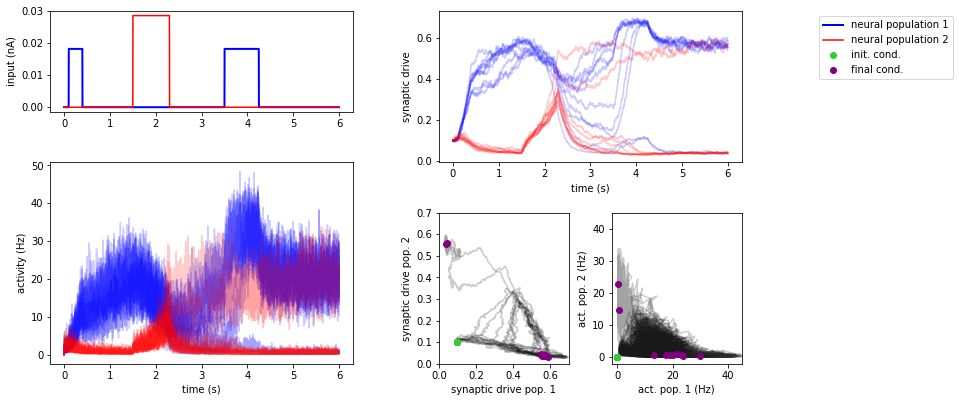

In [5]:
nTrials = 10

S1, S2, R1, R2, I1, I2, Td = network.simulation(I_1=35, I_2=55, I_12= 35, 
                                               t= 6, dt = 0.1/100,
                                               t1=.1, t2=1.5, t12=3.5, 
                                               pulse_t1=.3,  pulse_t2=.8, pulse_t12=.75, 
                                               n_trial=nTrials)
plot_NetworkAct_Input(Td, I1, I2, R1, R2, S1, S2)

## High-dimensional observations: generate spiking data from latents

In [6]:
# Signal scaling ([-10, 10])
c = np.stack((S1, S2))
# cc = ((( c - 0.1 ) / ( 0.6 - 0.1 )) * ( 10. - (-10.) )) - 10.

# Oversample by interpolation
zdim = c.shape[0]
dt = 1e-3
dtsign = 10
tmax = np.max(100)*dtsign
timed = np.arange(0,tmax,dt)
n_step = len(timed)
signscal = 10 # scal the signal in a +/- this value range to fit for the neuron
print(n_step)

newT = np.array(100*dtsign/dt,dtype='int')
ma_x = np.zeros([zdim, newT, nTrials])

for ii in range(nTrials):
    f1 = interpolate.interp1d(np.arange(len(Td)), c[0,:,ii], kind='cubic')
    f2 = interpolate.interp1d(np.arange(len(Td)), c[1,:,ii], kind='cubic')

    xnew = np.linspace(0, np.max(len(Td))-1, n_step)
#     ma_x[:,:,ii] == np.array([f1(xnew), f2(xnew)])
    x_ups = np.array([f1(xnew), f2(xnew)])
    
    for jj in range(zdim):
        ma_x[jj,:,ii] = ((x_ups[jj,:]-np.min(x_ups[jj,:]))/
                         (np.max(x_ups[jj,:])-np.min(x_ups[jj,:]))*2-1)*signscal

1000000


In [7]:
# Numerical Simulation parameters
# dt = 0.1/1000
# t = 6
# T = np.arange(0,t,dt)
# n_step = len(T)
# signscal = 1000 # scal the signal in a +/- this value range to fit for the neuron

xdim = 100 # Number of neurons
nu = 10e-3 # linear Spike Cost
mu = 10e-4 # quadratic cost: distributing activity
lbd_d = 1  # 4  # Readout Decay Rate, time constant of the decoder
lbd_v = 1  # Membrane Leak, time constant of the membrane
decoderscaling = 100 #*scal/MOD.ydim*1000# **4 # 1* scal > to do

In [8]:
np.random.seed(1)
SM = spiking()
SM.par(tmax, dt, timed, n_step, xdim, nu, mu, lbd_d, lbd_v, decoderscaling, J=zdim)

Omega, TT, D = SM.connect(Dtyp='hetero')

tt = 3
O, V, R, X_hat = SM.mixednet(ma_x[:,:,tt], D, Omega, TT, seed=0, thresh_nois_sig=0.0079) # thrNS 0.0099

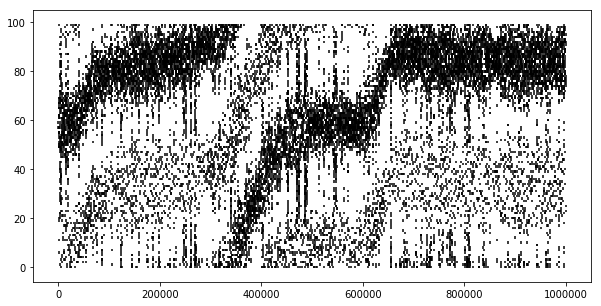

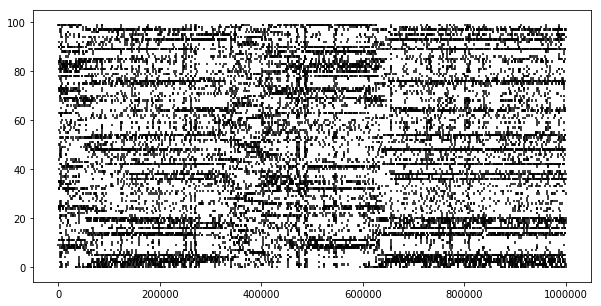

In [9]:
spksT = np.arange(O.shape[1])
spks = [spksT[O[i, :]>0] for i in range(O.shape[0])]
idxs = np.arange(O.shape[0])
np.random.shuffle(idxs)
spks_rnd = [spksT[O[i, :]>0] for i in idxs]

plt.figure(facecolor='w', figsize=(10, 5))
plt.eventplot(spks, colors='k');
plt.show()

plt.figure(facecolor='w', figsize=(10, 5))
plt.eventplot(spks_rnd, colors='k');
plt.show()

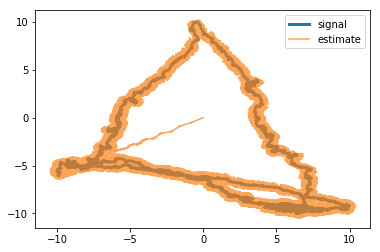

In [10]:
plt.figure(facecolor='w')
plt.plot(ma_x[0,:,tt], ma_x[1,:,tt], lw=3)
plt.plot(X_hat[0, :], X_hat[1, :], alpha=.7)
plt.legend(['signal', 'estimate']);

In [11]:
# plt.figure(facecolor='w')
# plt.plot(ma_x[0,:,0], ma_x[1,:,0])
# plt.plot(ma_x[0,:,3], ma_x[1,:,3])
# plt.legend(['signal', 'estimate']);

## Data preprocessing: smoothing

In [12]:
dtsign = 10#.005 # binning >>>
dsamp = np.arange(0, n_step, 1/dt*dtsign)
smthT = len(dsamp)
dtim = timed[dsamp.astype(int)]
dspikesT = np.zeros((xdim, smthT, nTrials))
print(smthT)


# optionally smooth through binning and averaging
for tt in range(nTrials):
    Omega, TT, D = SM.connect(Dtyp='hetero')
    O, V, R, X_hat = SM.mixednet(ma_x[:,:,tt], D, Omega, TT, seed=0, thresh_nois_sig=0.0079)
    
    for ii in range(smthT):
        dspikesT[:,ii,tt] = np.sum(O[:,np.int(dsamp[ii]):np.int(dsamp[ii]+1/dt*dtsign-1)], axis=1)

100


In [13]:
sub_x = ma_x[:, 1:n_step:int(n_step/smthT), :]

subN = 100 # subset of population >>>
ix = idxs[:subN] 

dspikes = np.sqrt(dspikesT[ix, :, :])
xdim = dspikes.shape[0]
print('Using '+str(subN)+' neurons')

Using 100 neurons


# Static LSM: PCA/FA

In [14]:
from sklearn.decomposition import PCA
X = dspikes.reshape((xdim, smthT* nTrials), order='F')
X = np.swapaxes(X, 0, 1)
X_avg = np.mean(dspikes, 2)
X_avg = np.swapaxes(X_avg, 0, 1)

In [15]:
pca_dim = 2
pca = PCA(n_components=xdim)
pca.fit(X)
Z_PCA = pca.transform(X)

pca_avg = PCA(n_components=pca_dim)
pca_avg.fit(X_avg)
Z_PCAavg = np.swapaxes(pca_avg.transform(X_avg), 0, 1)
Z_PCAavg = np.swapaxes(np.swapaxes([Z_PCAavg for i in range(nTrials)], 0,1), 1,2)

In [16]:
a = np.swapaxes(Z_PCA[:, :pca_dim], 0, -1)
b_PCA = np.reshape(a, (pca_dim, smthT, nTrials), order='F')

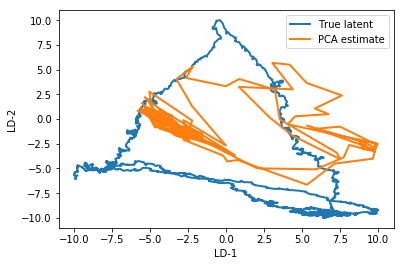

In [17]:
kk = 3
plt.plot(ma_x[0,:,kk], ma_x[1,:,kk], lw=2)
plt.plot(b_PCA[0,:,kk], b_PCA[1,:,kk], lw=2);
plt.xlabel('LD-1')
plt.ylabel('LD-2')
plt.legend(['True latent', 'PCA estimate']);

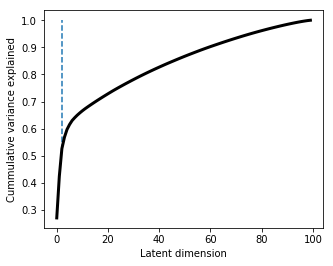

In [18]:
plt.figure(figsize=(5,4), facecolor='w')
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=3, c='k')
plt.xlabel('Latent dimension')
plt.ylabel('Cummulative variance explained')
plt.vlines(2, 0.52, 1, linestyles='--', colors='#1f77b4');

In [19]:
from FA_utils import FA_EM, FA_project

In [20]:
X_mu = np.mean(X.T, axis=1);              # data mean
X_cov = np.cov(X.T)                       # data covariance
xDim = len(X_mu);                         # observation space dimensions
if np.linalg.det(X_cov) < 1e-7:
    print('Warning! The determinant of the covariance matrix is quite low')
if np.linalg.matrix_rank(X.T) < X.shape[1]:
    print('Warning! Data matrix is not full rank')

zDims = np.arange(50)+2                 # latent space dimensions
eps = 1e-5                              # define stopping value
LL_dim = []                             # max LL per dim

Cs = []
Rs = []
LL_cache = []
LL_corrected = []

for zDim in zDims:
#     print(zDim)
    tC, tR, tLL_cache, tLL_corrected = FA_EM(X_cov, xDim, zDim, eps, X.shape[0])
    Cs.append(tC)
    Rs.append(tR)
    LL_cache.append(tLL_cache)
    LL_corrected.append(tLL_corrected)

Warning! The determinant of the covariance matrix is quite low


In [21]:
rzDim = 0
Re = Rs[rzDim]
Ce = Cs[rzDim]
Z_FA = FA_project(Ce, Re, X, X_mu)

b_FA = np.reshape(Z_FA, (zDims[rzDim], smthT, nTrials), order='F')

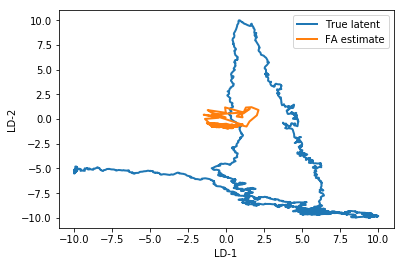

In [22]:
plt.plot(ma_x[0,:,0], ma_x[1,:,0], lw=2)
plt.plot(b_FA[0, :, 0], b_FA[1, :, 0], lw=2);
plt.xlabel('LD-1')
plt.ylabel('LD-2')
plt.legend(['True latent', 'FA estimate']);

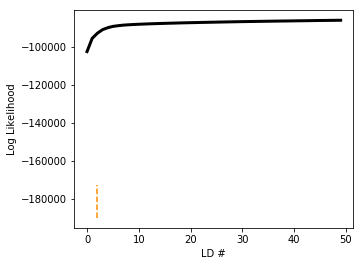

In [23]:
LLDim_plot = plt.figure(figsize=(5,4), facecolor='w')
LLDim_plot = plt.plot(np.array([i[-1] for i in LL_cache]), c='k', lw=3)
LLDim_plot = plt.xlabel('LD #')
LLDim_plot = plt.ylabel('Log Likelihood')
plt.vlines(2, -190000, -172500, linestyles='--', colors='darkorange');

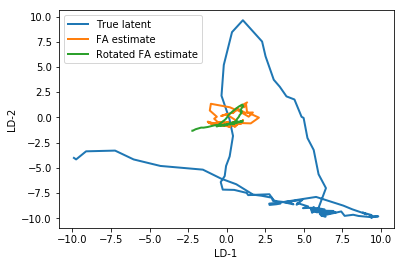

In [24]:
# subsampled = ma_x[:, 1:n_step:int(n_step/b_PCA.shape[1]), :]
kk = 3

errT = []

for ttt in range(sub_x.shape[2]):
    cosa1 = sub_x[:,:,ttt]
    cosa2 = b_FA[:,:,ttt]

    Rotat, sca = orthogonal_procrustes(cosa2, cosa1)

    cosa3 = np.dot(cosa2, Rotat)

    err = 0
    for ii in range(cosa1.shape[0]):
        err += np.corrcoef(cosa1[ii, :], cosa3[ii, :])[0,1]
        
    errT.append(err)

plt.plot(cosa1[0,:], cosa1[1,:], lw=2)
plt.plot(cosa2[0,:], cosa2[1,:], lw=2);
plt.plot(cosa3[0,:], cosa3[1,:], lw=2);
plt.xlabel('LD-1')
plt.ylabel('LD-2')
plt.legend(['True latent', 'FA estimate', 'Rotated FA estimate']);

# Dynamic LSM: KF/LDS

In [25]:
from KF_utils import KF_em_MT, KF_smooth

X_KF = np.sqrt(np.swapaxes(dspikes, 0,2)) # now: trials, time, xDim

n_dim_state = 2

init_A = np.eye(n_dim_state)#*.2
init_Q = np.eye(n_dim_state)#*.2
init_mu0 = np.zeros(n_dim_state)
init_cov0 = np.eye(n_dim_state)#*.5

init_R = Rs[0]
init_C = Cs[0]

In [26]:
mu0, cov0, A, Q, C, R, _ = KF_em_MT(init_A, init_Q, 
                                    init_C, init_R, 
                                    init_mu0, init_cov0, 
                                    X_KF, n_dim_state, 
                                    max_iter=10, LL_flag= False)

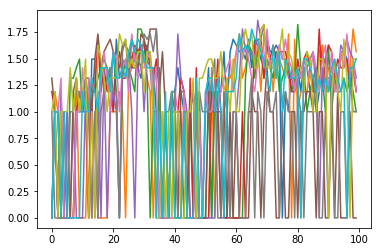

In [27]:
plt.plot(X_KF[:, :, 4].T);
# plt.plot(X_KF[7, 0, :])

In [28]:
ttt = 2
Z_mean, Z_cov, _ = KF_smooth(A, Q, C, R, mu0, cov0, X_KF[ttt, :,:], n_dim_state)

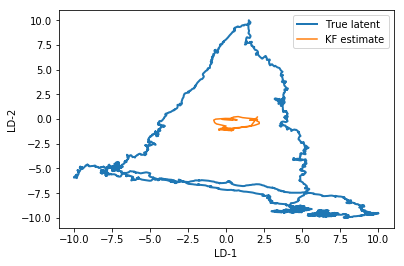

In [29]:
plt.plot(ma_x[0,:,ttt], ma_x[1,:,ttt], lw=2)
plt.plot(Z_mean[:, 0], Z_mean[:, 1])
plt.xlabel('LD-1')
plt.ylabel('LD-2')
plt.legend(['True latent', 'KF estimate']);

In [30]:
Z_KF = np.zeros((n_dim_state, smthT, nTrials))*np.nan
for ttt in range(nTrials):
    Z_mean, Z_cov, _ = KF_smooth(A, Q, C, R, mu0, cov0, X_KF[ttt, :,:], n_dim_state)
    Z_KF[:,:,ttt] = Z_mean.T

nDim = [2, 3, 4, 5]

KF_ll = []
for ii in nDim:
    
    init_A = np.eye(ii)#*.2
    init_Q = np.eye(ii)#*.2
    init_mu0 = np.zeros(ii)
    init_cov0 = np.eye(ii)#*.5

    init_R = Rs[ii-2]
    init_C = Cs[ii-2]
    
    _, _, _, _, _, _, LL = KF_em_MT(init_A, init_Q, 
                                        init_C, init_R, 
                                        init_mu0, init_cov0, 
                                        X_KF, ii, 
                                        max_iter=10, LL_flag= True)
    KF_ll.append(LL[-1])

LLDim_plot = plt.figure(facecolor='w')
LLDim_plot = plt.plot(KF_ll, c='k', lw=3)
LLDim_plot = plt.xlabel('LD #')
LLDim_plot = plt.ylabel('Log Likelihood')

# Dynamic LSM: P-GPFA

In [31]:
import funs.util as util
import funs.engine as engine

# Initialize random number generator
np.random.seed(123)

data = []
for ii in range(nTrials):
    temp_dict = {}
    temp_dict['Y'] = dspikes[:,:,ii]
    data.append(temp_dict)

# dataset = {}

# dataset['data'] = data
# dataset['T'] = smthT
trialDur = 6000 # simluation time 6 sec
binSize = int(6000/smthT) 
dOffset = 1

training_set  = util.dataset(
                            seed      = np.random.randint(10000),
                            xdim      = n_dim_state,
                            ydim      = xdim,
                            numTrials = 1,
                            trialDur  = trialDur,
                            binSize   = binSize,
                            dOffset   = dOffset,
                            fixTau    = True, 
                            fixedTau  = np.linspace(0.1,0.5,xdim),
                            drawSameX = True)

training_set.data = data

initParams = util.initializeParams(n_dim_state, xdim, training_set)

+------------- Simulated Dataset Options -------------+
                                                    2 | Dimensionality of Latent State
                                                  100 | Dimensionality of Observed State (# neurons)
                                                 6000 | Duration of trials (ms):
                                                   60 | Size of bins (ms):
                                                    1 | Number of Trials
+-----------------------------------------------------+
Sampling trial 1 ...
Average firing rate per neuron in this dataset: 20.322 Hz.
Initializing parameters with Poisson-PCA..


In [32]:
fitBatch = engine.PPGPFAfit(
                            experiment      = training_set,
                            initParams      = initParams,
                            inferenceMethod = 'laplace',
                            EMmode          = 'Batch',
                            maxEMiter       = 20)

+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                  100 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   20 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  20 of  20, nPLL: = -8097.3170
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [33]:
Z_meanGP = np.array(fitBatch.infRes['post_mean'])
Z_meanGP1 = np.swapaxes(Z_meanGP, 0,1)
Z_GP = np.swapaxes(Z_meanGP1, 1,2)

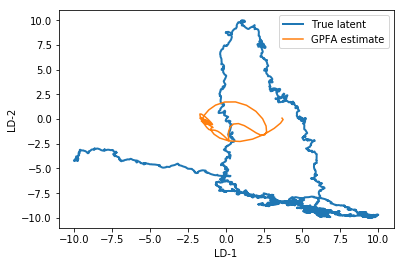

In [34]:
plt.plot(ma_x[0,:,ttt], ma_x[1,:,ttt], lw=2)
plt.plot(Z_GP[0,:,ttt], Z_GP[1,:,ttt])
plt.xlabel('LD-1')
plt.ylabel('LD-2')
plt.legend(['True latent', 'GPFA estimate']);

In [ ]:
nDim = [1, 2, 3, 4, 5]
GP_ll = []
for ii in nDim:
    training_set  = util.dataset(
                                seed      = np.random.randint(10000),
                                xdim      = ii,
                                ydim      = xdim,
                                numTrials = 1,
                                trialDur  = trialDur,
                                binSize   = binSize,
                                dOffset   = dOffset,
                                fixTau    = True, 
                                fixedTau  = np.linspace(0.1,0.5,xdim),
                                drawSameX = True)

    training_set.data = data

    initParams = util.initializeParams(ii, xdim, training_set)
    fitBatches = engine.PPGPFAfit(
                                experiment      = training_set,
                                initParams      = initParams,
                                inferenceMethod = 'laplace',
                                EMmode          = 'Batch',
                                maxEMiter       = 20)

    GP_ll.append(fitBatches.posteriorLikelihood[-1])

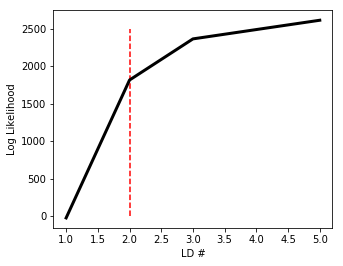

In [36]:
nDim = [1, 2, 3, 4, 5]
LLDim_plot = plt.figure(figsize=(5, 4), facecolor='w')
LLDim_plot = plt.plot(nDim, GP_ll, c='k', lw=3)
LLDim_plot = plt.xlabel('LD #')
LLDim_plot = plt.ylabel('Log Likelihood')
plt.vlines(2, 0, 2500, linestyles='--', colors='red');

# Model evaluation

In [37]:
print(sub_x.shape)
print(b_PCA.shape)
print(Z_PCAavg.shape)
print(b_FA.shape)
print(Z_KF.shape)
print(Z_GP.shape)

(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)


In [38]:
err_PCA = fitting_err(sub_x, b_PCA)
err_PCAavg = fitting_err(sub_x, Z_PCAavg)
err_FA  = fitting_err(sub_x, b_FA) 
err_KF  = fitting_err(sub_x, Z_KF) 
err_GP  = fitting_err(sub_x, Z_GP) 

perfM = np.stack([err_PCA, err_FA, err_KF, err_GP])
np.mean(perfM, axis=1)

array([0.88159506, 0.85592999, 0.94966762, 0.8550919 ])

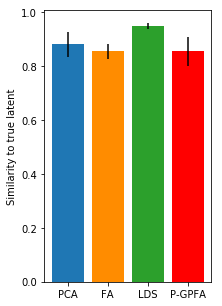

In [39]:
plt.figure(figsize=(3,5),facecolor='w')
plt.bar(range(4), np.mean(perfM, axis=1), 
        yerr= scipy.stats.sem(perfM, axis=1), 
        color=['#1f77b4', 'darkorange', '#2ca02c','red'])
plt.xticks(range(4),['PCA','FA','LDS','P-GPFA'])
# plt.legend([])
plt.ylabel('Similarity to true latent');

kk = 1
cmap=['#1f77b4', 'darkorange', '#2ca02c','red']
# b_PCA b_FA Z_KF Z_GP
cosa1 = sub_x[:,:,kk]
cosa2 = b_PCA[:,:,kk]
Rotat, sca = orthogonal_procrustes(cosa2, cosa1)

cosa3 = (np.dot(cosa2, Rotat))*.5

plt.figure(figsize=(5,5), facecolor='w')
plt.plot(cosa1[0,:], cosa1[1,:], lw=3, c='k')
# plt.plot(cosa2[0,:], cosa2[1,:], lw=2);
plt.plot(cosa3[0,:], cosa3[1,:], lw=3, c=cmap[0]);
plt.xlabel('LD-1')
plt.ylabel('LD-2')
plt.legend(['True latent', 'FA estimate', 'Rotated FA estimate']);